In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!pip install geemap

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=lZNaGsPTZdeDMuNSfve9AI7Hu82yRvk1t0-_7sBovAY&tc=byyiYa8vg1M2baXpZLCPW2yF3XBmj4jPf1kQyEsAAgg&cc=_OQXknHZDnBP5vye6z43HS3DC_yg0JARP9OXNQovkb8

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AWgavddM7vX1PJsfUCkg8TET5k6ESqHUOrFa77tFq9HRxVHQ1xwkS3IHCfg

Successfully saved authorization token.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# import geemap
import datetime
import numpy as np
import math

In [ ]:
area = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020_the_second_method/four')

In [ ]:
def maskS2clouds(image):
    qa = image.select('QA60');
    cloudBitMask = 1 << 10;
    cirrusBitMask = 1 << 11;
    mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
      .And(qa.bitwiseAnd(cirrusBitMask).eq(0));
    return image.updateMask(mask);

def clip(image):
    image = image.clip(area);
    return image;

In [ ]:
start_time = "2020-02-01"
end_time = "2020-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
print(image_number.getInfo())

20


In [ ]:
# 构建NDVI时间序列
def NDVI_timeMax(start_time,end_time,day_gap,image_number):

  def NDVI(image):
    nir = image.select("B8");
    red = image.select("B4");
    ndvi = nir.subtract(red).divide(nir.add(red));
    return image.select().addBands(ndvi);

  image_list = []
  NDVI_list = []

  for i in range(image_number.getInfo()):
      s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
      e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
      s_time = s_date.strftime("%Y-%m-%d");
      e_time = e_date.strftime("%Y-%m-%d");
      NDVI_image = ee.ImageCollection("COPERNICUS/S2_SR")\
                    .filterDate(s_time, e_time)\
                    .map(clip).filterBounds(area).map(NDVI).max().rename("NDVI").set("data",s_date)\
                    .set('system:footprint',area.geometry())
      ddiff = ee.Date(s_time).difference(ee.Date(start_time), 'day')
      new_NDVI_image = NDVI_image.addBands(ee.Image(1).toFloat().rename('constant'))\
                                .addBands(ee.Image(ddiff).toFloat().rename('t'))\
                                .addBands(ee.Image(ddiff).pow(ee.Image(2)).toFloat().rename('t2'))\
                                .addBands(ee.Image(ddiff).pow(ee.Image(3)).toFloat().rename('t3'))
      globals()["NDVI_image"+s_date.strftime("%Y%m%d")] = NDVI_image
      image_list.append(globals()["NDVI_image"+s_date.strftime("%Y%m%d")])
      NDVI_list.append("NDVI"+'{:0>2d}'.format(i))

  NDVI_col = ee.ImageCollection(image_list)
  NDVI_image = NDVI_col.toBands().rename(NDVI_list)
  return NDVI_col,NDVI_image

In [ ]:
NDVI = NDVI_timeMax(start_time,end_time,day_gap,image_number)
NDVI_col = NDVI[0]
NDVI_image = NDVI[1]

In [ ]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [ ]:
Map.addLayer(NDVI_image)

In [ ]:
corn = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/origin_point/corn').filterBounds(area)
cotton = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/origin_point/cotton').filterBounds(area)
forest = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/origin_point/nut').filterBounds(area)
wheat = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/origin_point/wheat').filterBounds(area)
# wheat_corn = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/origin_point/wheat_corn').filterBounds(area)
other = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/origin_point/other').filterBounds(area)

In [ ]:
corn_result = NDVI_image.sampleRegions(corn, scale=10, tileScale=8)
geemap.ee_export_vector_to_drive(corn_result, description="corn", folder="原始样本点NDVI时间序列", fileNamePrefix=None, fileFormat="csv")
cotton_result = NDVI_image.sampleRegions(cotton, scale=10, tileScale=8)
geemap.ee_export_vector_to_drive(cotton_result, description="cotton", folder="原始样本点NDVI时间序列", fileNamePrefix=None, fileFormat="csv")
forest_result = NDVI_image.sampleRegions(forest, scale=10, tileScale=8)
geemap.ee_export_vector_to_drive(forest_result, description="forest", folder="原始样本点NDVI时间序列", fileNamePrefix=None, fileFormat="csv")
wheat_result = NDVI_image.sampleRegions(wheat, scale=10, tileScale=8)
geemap.ee_export_vector_to_drive(wheat_result, description="wheat", folder="原始样本点NDVI时间序列", fileNamePrefix=None, fileFormat="csv")
# wheat_corn_result = NDVI_image.sampleRegions(wheat_corn, scale=10, tileScale=8)
# geemap.ee_export_vector_to_drive(wheat_corn_result, description="wheat_corn", folder="原始样本点NDVI时间序列", fileNamePrefix=None, fileFormat="csv")
other_result = NDVI_image.sampleRegions(other, scale=10, tileScale=8)
geemap.ee_export_vector_to_drive(other_result, description="other", folder="原始样本点NDVI时间序列", fileNamePrefix=None, fileFormat="csv")

Exporting corn... Please check the Task Manager from the JavaScript Code Editor.
Exporting cotton... Please check the Task Manager from the JavaScript Code Editor.
Exporting forest... Please check the Task Manager from the JavaScript Code Editor.
Exporting wheat... Please check the Task Manager from the JavaScript Code Editor.
Exporting other... Please check the Task Manager from the JavaScript Code Editor.


In [3]:
import csv
import os, sys
import glob
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 打开矢量
csv_origin_dir = r"/content/gdrive/MyDrive/原始样本点NDVI时间序列"
os.chdir(csv_origin_dir)
CSV_list = glob.glob("*.csv")
print(CSV_list)
NDVI = []
i = 0
print(CSV_list[i])
with open(os.path.join(csv_origin_dir, CSV_list[i]), encoding='utf-8-sig') as f :
  for row in csv.reader(f, skipinitialspace=True):
    NDVI.append(row)
n = np.array(NDVI).shape[0]
print(NDVI)
dataSet = []
for i in range(1, n):
  a = list(map(float, NDVI[i][1:20]))
  dataSet.append(a)
band = range(len(NDVI[0][1:20]))
print(band)
# for i in range(1, n-1):
# plt.plot(band, dataSet[i], 'b-')

['forest.csv', 'wheat.csv', 'corn.csv', 'other.csv', 'cotton.csv']
forest.csv
[['system:index', 'NDVI00', 'NDVI01', 'NDVI02', 'NDVI03', 'NDVI04', 'NDVI05', 'NDVI06', 'NDVI07', 'NDVI08', 'NDVI09', 'NDVI10', 'NDVI11', 'NDVI12', 'NDVI13', 'NDVI14', 'NDVI15', 'NDVI16', 'NDVI17', 'NDVI18', 'NDVI19', '_样点_', 'class', 'system_ind', '备注', '常年耕_', '纬度', '经度', '.geo'], ['00000000000000000000_0', '0.22485021', '0.16299559', '0.13864578', '0.17300862', '0.24064769', '0.68914694', '0.6932153', '0.66533864', '0.63783664', '0.6637681', '0.7717391', '0.86603993', '0.90017825', '0.79469204', '0.6651481', '0.60876787', '0.53203607', '0.27651748', '0.32607785', '0.26920506', 'XH-16', 'Nut', '00000000000000000032', '', '', '41.569842', '82.589739', '{"type":"MultiPoint","coordinates":[]}'], ['00000000000000000001_0', '0.26046386', '0.17970401', '0.15170279', '0.17479074', '0.26420736', '0.5798239', '0.71492004', '0.64547294', '0.87104386', '0.78900385', '0.888', '0.89863235', '0.8784029', '0.7682525', '0.

In [ ]:
from sklearn.cluster import KMeans
import joblib
import numpy
import time
import matplotlib.pyplot as plt
from google.colab import files

estimator = KMeans(n_clusters=4)#构造聚类器
estimator.fit(dataSet)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和

result = estimator.fit_predict(dataSet)

print("Predicting result: ", result)
# print(len(dataSet))
numSamples = len(dataSet)
# print(centroids,type(centroids)) #显示中心点
# print(estimator.inertia_) #显示聚类效果
mark = ['-r', '-b', '-g', '-k', '^r', '+r', 'sr', 'dr', '<r', 'pr']

Predicting result:  [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 1 2 2 0 2 1 0 0 3 2 3 1 0 3 0
 0 3 0 0 2 0 3 0 2 3 1 0 0 3 0 2 3 2 3 0 0 0 0 0 3 3 0 0 0]


In [ ]:
# def Multipoin2feature(feature):
#   geomList = ee.Feature(feature).geometry().geometries();
#   def GetGeom(geom):
#     return ee.Feature(ee.Geometry(geom));
#   featureList = geomList.map(GetGeom)
#   return featureList;

# multiGeomExplodeList = cotton.toList(cotton.size()).map(Multipoin2feature).flatten();
# multiGeomExplodeFc = ee.FeatureCollection(multiGeomExplodeList);
# print(multiGeomExplodeFc.getInfo());

# size=multiGeomExplodeFc.size()
# toList = multiGeomExplodeFc.toList(size)
# idList = ee.List.sequence(0, size.subtract(1))
# model_list = ee.List(result.tolist())

# def add_property(x):
#   index = model_list.get(x)
#   feat = toList.get(x)
#   return ee.Feature(feat).set('model', index).copyProperties(feat)

# newList = idList.map(add_property)
# print(newList.getInfo(), 'newList')

number = 40


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

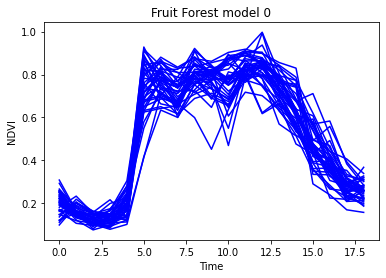

In [ ]:
i = 0
a = 0
fig, ax = plt.subplots()
for j in range(1, len(result)):
  if result[j] == i:
    a = a+1
    plt.plot(band, dataSet[j], 'b-')
# plt.plot(band, centroids[i], '-b')
print("number = {}".format(a))
# print(corn_model_1_lon)
# print(corn_model_1_lat)
ax.set_xlabel('Time')
ax.set_ylabel('NDVI')
ax.set_title('Fruit Forest model 1')
plt.savefig('Fruit Forest model 1.svg',format='svg')
files.download('Fruit Forest model 1.svg') 

number = 4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

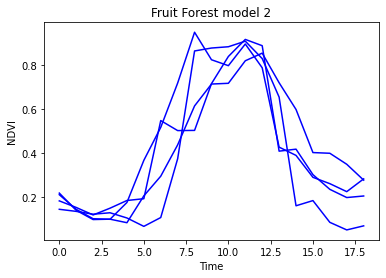

In [ ]:
i = 1
a = 0
fig, ax = plt.subplots()
for j in range(1, len(result)):
  if result[j] == i:
    a = a+1
    plt.plot(band, dataSet[j], 'b-')
# plt.plot(band, centroids[i], '-b')
print("number = {}".format(a))
# print(corn_model_1_lon)
# print(corn_model_1_lat)
ax.set_xlabel('Time')
ax.set_ylabel('NDVI')
ax.set_title('Fruit Forest model 2')
plt.savefig('Fruit Forest model 2.svg',format='svg')
files.download('Fruit Forest model 2.svg') 

number = 10


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

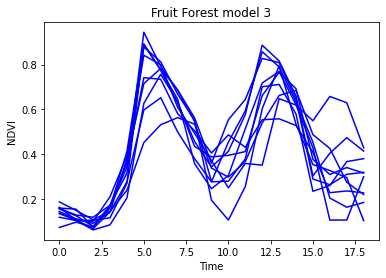

In [ ]:
i = 2
a = 0
fig, ax = plt.subplots()
for j in range(1, len(result)):
  if result[j] == i:
    a = a+1
    plt.plot(band, dataSet[j], 'b-')
# plt.plot(band, centroids[i], '-b')
print("number = {}".format(a))
# print(corn_model_1_lon)
# print(corn_model_1_lat)
ax.set_xlabel('Time')
ax.set_ylabel('NDVI')
ax.set_title('Fruit Forest model 3')
plt.savefig('Fruit Forest model 3.svg',format='svg')
files.download('Fruit Forest model 3.svg') 

number = 11


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

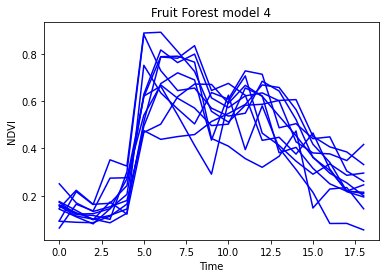

In [ ]:
i = 3
a = 0
fig, ax = plt.subplots()
for j in range(1, len(result)):
  if result[j] == i:
    a = a+1
    plt.plot(band, dataSet[j], 'b-')
# plt.plot(band, centroids[i], '-b')
print("number = {}".format(a))
# print(corn_model_1_lon)
# print(corn_model_1_lat)
ax.set_xlabel('Time')
ax.set_ylabel('NDVI')
ax.set_title('Fruit Forest model 4')
plt.savefig('Fruit Forest model 4.svg',format='svg')
files.download('Fruit Forest model 4.svg') 

In [ ]:
# geemap.ee_export_vector_to_asset(ee.FeatureCollection(newList), description='N_cotton', assetId="projects/ee-gaoliaoran2020/assets/N_cotton")

projects/ee-gaoliaoran2020/assets/N_cotton
Exporting N_cotton... Please check the Task Manager from the JavaScript Code Editor.


In [ ]:
# 打开矢量
csv_origin_dir = r"/content/gdrive/MyDrive/原始样本点NDVI时间序列"
os.chdir(csv_origin_dir)
CSV_list = glob.glob("*.csv")
print(CSV_list)
NDVI = []
i = 1
print(CSV_list[i])
with open(os.path.join(csv_origin_dir, CSV_list[i]), encoding='utf-8-sig') as f :
  for row in csv.reader(f, skipinitialspace=True):
    NDVI.append(row)
n = np.array(NDVI).shape[0]
dataSet = []
for i in range(1, n):
  a = list(map(float, NDVI[i][1:20]))
  dataSet.append(a)
band = range(len(NDVI[0][1:20]))
print(band)
# for i in range(1, n-1):
# plt.plot(band, dataSet[i], 'b-')

from sklearn.cluster import KMeans
import joblib
import numpy
import time
import matplotlib.pyplot as plt

estimator = KMeans(n_clusters=4)#构造聚类器
estimator.fit(dataSet)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和

result = estimator.fit_predict(dataSet)

print("Predicting result: ", result)
# print(len(dataSet))
numSamples = len(dataSet)
# print(centroids,type(centroids)) #显示中心点
# print(estimator.inertia_) #显示聚类效果
mark = ['-r', '-b', '-g', '-k', '^r', '+r', 'sr', 'dr', '<r', 'pr']

['forest.csv', 'wheat.csv', 'corn.csv', 'other.csv', 'cotton.csv']
wheat.csv
range(0, 19)
Predicting result:  [3 3 2 1 2 1 0 3 1 2 1 0 0 3 3 1 2 3 1 3 0 3 3 0 2 1 3 1 1 1]


In [ ]:
# def Multipoin2feature(feature):
#   geomList = ee.Feature(feature).geometry().geometries();
#   def GetGeom(geom):
#     return ee.Feature(ee.Geometry(geom));
#   featureList = geomList.map(GetGeom)
#   return featureList;

# multiGeomExplodeList = wheat.toList(wheat.size()).map(Multipoin2feature).flatten();
# multiGeomExplodeFc = ee.FeatureCollection(multiGeomExplodeList);
# print(multiGeomExplodeFc.getInfo());

# size=multiGeomExplodeFc.size()
# toList = multiGeomExplodeFc.toList(size)
# idList = ee.List.sequence(0, size.subtract(1))
# model_list = ee.List(result.tolist())

# def add_property(x):
#   index = model_list.get(x)
#   feat = toList.get(x)
#   return ee.Feature(feat).set('model', index).copyProperties(feat)

# newList = idList.map(add_property)
# print(newList.getInfo(), 'newList')

number = 5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

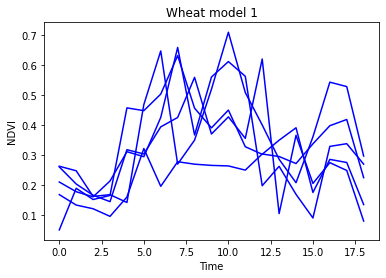

In [ ]:
i = 0
a = 0
fig, ax = plt.subplots()
for j in range(1, len(result)):
  if result[j] == i:
    a = a+1
    plt.plot(band, dataSet[j], 'b-')
# plt.plot(band, centroids[i], '-b')
print("number = {}".format(a))
# print(corn_model_1_lon)
# print(corn_model_1_lat)
ax.set_xlabel('Time')
ax.set_ylabel('NDVI')
ax.set_title('Wheat model 1')
plt.savefig('Wheat model 1.svg',format='svg')
files.download('Wheat model 1.svg') 

number = 10


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

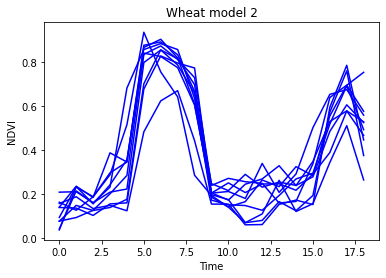

In [ ]:
i = 1
a = 0
fig, ax = plt.subplots()
for j in range(1, len(result)):
  if result[j] == i:
    a = a+1
    plt.plot(band, dataSet[j], 'b-')
# plt.plot(band, centroids[i], '-b')
print("number = {}".format(a))
# print(corn_model_1_lon)
# print(corn_model_1_lat)
ax.set_xlabel('Time')
ax.set_ylabel('NDVI')
ax.set_title('Wheat model 2')
plt.savefig('Wheat model 2.svg',format='svg')
files.download('Wheat model 2.svg')

number = 5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

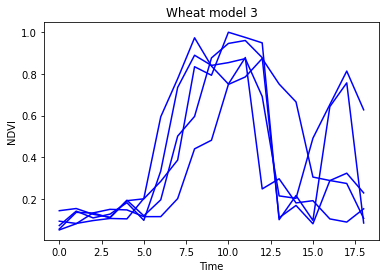

In [ ]:
i = 2
a = 0
fig, ax = plt.subplots()
for j in range(1, len(result)):
  if result[j] == i:
    a = a+1
    plt.plot(band, dataSet[j], 'b-')
# plt.plot(band, centroids[i], '-b')
print("number = {}".format(a))
# print(corn_model_1_lon)
# print(corn_model_1_lat)
ax.set_xlabel('Time')
ax.set_ylabel('NDVI')
ax.set_title('Wheat model 3')
plt.savefig('Wheat model 3.svg',format='svg')
files.download('Wheat model 3.svg')

number = 9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

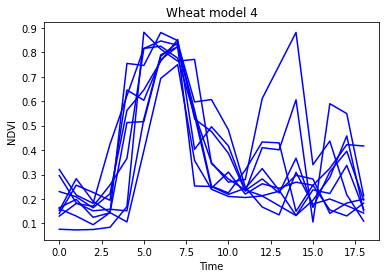

In [ ]:
i = 3
a = 0
fig, ax = plt.subplots()
for j in range(1, len(result)):
  if result[j] == i:
    a = a+1
    plt.plot(band, dataSet[j], 'b-')
# plt.plot(band, centroids[i], '-b')
print("number = {}".format(a))
# print(corn_model_1_lon)
# print(corn_model_1_lat)
ax.set_xlabel('Time')
ax.set_ylabel('NDVI')
ax.set_title('Wheat model 4')
plt.savefig('Wheat model 4.svg',format='svg')
files.download('Wheat model 4.svg')

In [ ]:
# geemap.ee_export_vector_to_asset(ee.FeatureCollection(newList), description='N_wheat', assetId="projects/ee-gaoliaoran2020/assets/N_wheat")

projects/ee-gaoliaoran2020/assets/N_wheat
Exporting N_wheat... Please check the Task Manager from the JavaScript Code Editor.


In [ ]:
# 打开矢量
csv_origin_dir = r"/content/gdrive/MyDrive/原始样本点NDVI时间序列"
os.chdir(csv_origin_dir)
CSV_list = glob.glob("*.csv")
print(CSV_list)
NDVI = []
i = 2
print(CSV_list[i])
with open(os.path.join(csv_origin_dir, CSV_list[i]), encoding='utf-8-sig') as f :
  for row in csv.reader(f, skipinitialspace=True):
    NDVI.append(row)
n = np.array(NDVI).shape[0]
dataSet = []
for i in range(1, n):
  a = list(map(float, NDVI[i][1:20]))
  dataSet.append(a)
band = range(len(NDVI[0][1:20]))
print(band)
# for i in range(1, n-1):
# plt.plot(band, dataSet[i], 'b-')

from sklearn.cluster import KMeans
import joblib
import numpy
import time
import matplotlib.pyplot as plt

estimator = KMeans(n_clusters=3)#构造聚类器
estimator.fit(dataSet)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和

result = estimator.fit_predict(dataSet)

print("Predicting result: ", result)
# print(len(dataSet))
numSamples = len(dataSet)
# print(centroids,type(centroids)) #显示中心点
# print(estimator.inertia_) #显示聚类效果
mark = ['-r', '-b', '-g', '-k', '^r', '+r', 'sr', 'dr', '<r', 'pr']

['forest.csv', 'cotton.csv', 'other.csv', 'corn.csv', 'wheat.csv']
other.csv
range(0, 19)
Predicting result:  [0 0 0 2 0 1 0 1 0 0 0 0 0 1 0 2 1 0 2 2 0 1 2 0 0 1 0 2 0 1 0 0 2 0 1 1 1
 0 2 0 2 0 0 1 1 1 1 0 0 1 1 0 0]


In [ ]:
# def Multipoin2feature(feature):
#   geomList = ee.Feature(feature).geometry().geometries();
#   def GetGeom(geom):
#     return ee.Feature(ee.Geometry(geom));
#   featureList = geomList.map(GetGeom)
#   return featureList;
# # --------------------------------------------------------------------------------------------------
# multiGeomExplodeList = forest.toList(forest.size()).map(Multipoin2feature).flatten();
# # --------------------------------------------------------------------------------------------------
# multiGeomExplodeFc = ee.FeatureCollection(multiGeomExplodeList);
# print(multiGeomExplodeFc.getInfo());

# size=multiGeomExplodeFc.size()
# toList = multiGeomExplodeFc.toList(size)
# idList = ee.List.sequence(0, size.subtract(1))
# model_list = ee.List(result.tolist())

# def add_property(x):
#   index = model_list.get(x)
#   feat = toList.get(x)
#   return ee.Feature(feat).set('model', index).copyProperties(feat)

# newList = idList.map(add_property)
# print(newList.getInfo(), 'newList')

{'type': 'FeatureCollection', 'columns': {'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [81.26816681260408, 41.86044422018077]}, 'id': '0', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [83.3791670106498, 41.45279802760402]}, 'id': '1', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [83.15155333139492, 41.68626354971364]}, 'id': '2', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [82.85147782375397, 41.574418110219156]}, 'id': '3', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [82.70209115108662, 41.578889313621175]}, 'id': '4', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [81.97136273553157, 41.756731981928425]}, 'id': '5', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [83.00528633639134, 41.677995623516

number = 27


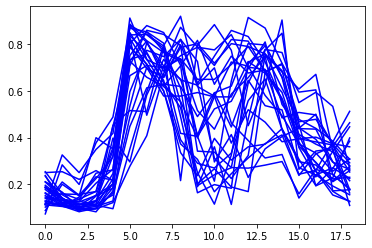

In [ ]:
i = 0
a = 0
for j in range(1, len(result)):
  if result[j] == i:
    a = a+1
    plt.plot(band, dataSet[j], 'b-')
print("number = {}".format(a))

number = 16


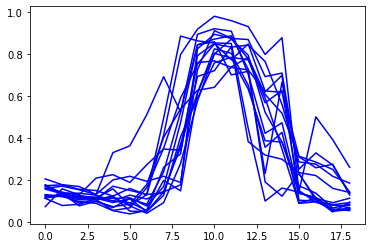

In [ ]:
i = 1
a = 0
for j in range(1, len(result)):
  if result[j] == i:
    a = a+1
    plt.plot(band, dataSet[j], 'b-')
print("number = {}".format(a))

number = 9


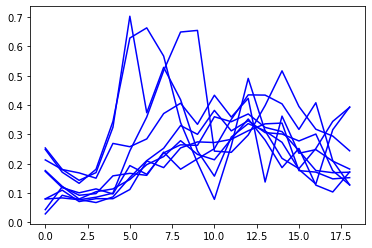

In [ ]:
i = 2
a = 0
for j in range(1, len(result)):
  if result[j] == i:
    a = a+1
    plt.plot(band, dataSet[j], 'b-')
print("number = {}".format(a))

In [ ]:
# # --------------------------------------------------------------------------------------------------
# geemap.ee_export_vector_to_asset(ee.FeatureCollection(newList), description='N_forest', assetId="projects/ee-gaoliaoran2020/assets/N_forest")
# # --------------------------------------------------------------------------------------------------

projects/ee-gaoliaoran2020/assets/N_forest
Exporting N_forest... Please check the Task Manager from the JavaScript Code Editor.


In [7]:
# 打开矢量
csv_origin_dir = r"/content/drive/MyDrive/原始样本点NDVI时间序列"
os.chdir(csv_origin_dir)
CSV_list = glob.glob("*.csv")
print(CSV_list)
NDVI = []
i = 2
print(CSV_list[i])
with open(os.path.join(csv_origin_dir, CSV_list[i]), encoding='utf-8-sig') as f :
  for row in csv.reader(f, skipinitialspace=True):
    NDVI.append(row)
n = np.array(NDVI).shape[0]
dataSet = []
for i in range(1, n):
  a = list(map(float, NDVI[i][1:20]))
  dataSet.append(a)
band = range(len(NDVI[0][1:20]))
print(band)
# for i in range(1, n-1):
# plt.plot(band, dataSet[i], 'b-')

from sklearn.cluster import KMeans
import joblib
import numpy
import time
import matplotlib.pyplot as plt

estimator = KMeans(n_clusters=3)#构造聚类器
estimator.fit(dataSet)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和

result = estimator.fit_predict(dataSet)

print("Predicting result: ", result)
# print(len(dataSet))
numSamples = len(dataSet)
# print(centroids,type(centroids)) #显示中心点
# print(estimator.inertia_) #显示聚类效果
mark = ['-r', '-b', '-g', '-k', '^r', '+r', 'sr', 'dr', '<r', 'pr']

['forest.csv', 'wheat.csv', 'corn.csv', 'other.csv', 'cotton.csv']
corn.csv
range(0, 19)
Predicting result:  [1 0 2 1 0 0 2 1 0 2 1 1 1 2 1 1 1 0 0 0 1 1 0 1 0 1 0 0 2 0 2 1 1 1 0 0 1
 1 1 0 1 1 2 1 1 0 1 0 2 0 1 2 0 1 0 0 1 1 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 2 1 2 0 0 0 0 0 1 2 0 0 2 0
 0 0 0 1 0 1 0 1 1 0 1]


In [ ]:
# def Multipoin2feature(feature):
#   geomList = ee.Feature(feature).geometry().geometries();
#   def GetGeom(geom):
#     return ee.Feature(ee.Geometry(geom));
#   featureList = geomList.map(GetGeom)
#   return featureList;
# # --------------------------------------------------------------------------------------------------
# multiGeomExplodeList = corn.toList(corn.size()).map(Multipoin2feature).flatten();
# # --------------------------------------------------------------------------------------------------
# multiGeomExplodeFc = ee.FeatureCollection(multiGeomExplodeList);
# print(multiGeomExplodeFc.getInfo());

# size=multiGeomExplodeFc.size()
# toList = multiGeomExplodeFc.toList(size)
# idList = ee.List.sequence(0, size.subtract(1))
# model_list = ee.List(result.tolist())

# def add_property(x):
#   index = model_list.get(x)
#   feat = toList.get(x)
#   return ee.Feature(feat).set('model', index).copyProperties(feat)

# newList = idList.map(add_property)
# print(newList.getInfo(), 'newList')

{'type': 'FeatureCollection', 'columns': {'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [82.37670663904098, 41.528269311687936]}, 'id': '0', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [83.02337989398144, 41.5002546405323]}, 'id': '1', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [81.52302696313566, 41.66361469849003]}, 'id': '2', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [81.84583654668373, 41.83236491785246]}, 'id': '3', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [81.10049666931285, 41.73841770843094]}, 'id': '4', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [82.29099593068996, 41.46027026794363]}, 'id': '5', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [81.94024614176959, 41.69664527098921

In [ ]:
# # --------------------------------------------------------------------------------------------------
# geemap.ee_export_vector_to_asset(ee.FeatureCollection(newList), description='N_corn', assetId="projects/ee-gaoliaoran2020/assets/N_corn")
# # --------------------------------------------------------------------------------------------------

projects/ee-gaoliaoran2020/assets/N_corn
Exporting N_corn... Please check the Task Manager from the JavaScript Code Editor.


In [11]:
print(centroids,type(centroids)) #显示中心点

[[0.12158111 0.13675252 0.11746047 0.15103779 0.13258463 0.17043263
  0.27664024 0.41980866 0.66803447 0.78002375 0.84764778 0.88367154
  0.82070537 0.68194665 0.56755694 0.27573394 0.27925092 0.25687497
  0.220651  ]
 [0.18912962 0.16427293 0.13208258 0.19464798 0.33711581 0.7622221
  0.75420526 0.67945632 0.5400911  0.3001087  0.30133083 0.42335871
  0.67139856 0.71340358 0.62512911 0.37784298 0.25212951 0.23372327
  0.25252499]
 [0.13209048 0.12179157 0.09799723 0.10780118 0.11269383 0.15604661
  0.14748286 0.17795986 0.22867734 0.30813468 0.44077756 0.54047112
  0.53756381 0.49572886 0.34320934 0.2375527  0.15690589 0.14316611
  0.15988474]] <class 'numpy.ndarray'>


number = 68


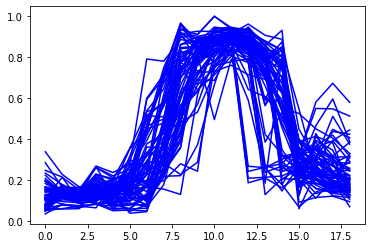

In [8]:
i = 0
a = 0
for j in range(1, len(result)):
  if result[j] == i:
    a = a+1
    plt.plot(band, dataSet[j], 'b-')
print("number = {}".format(a))

number = 37


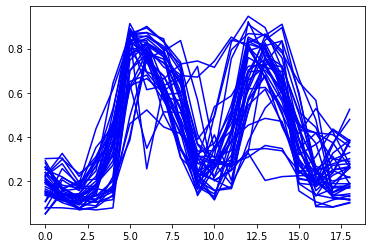

In [9]:
i = 1
a = 0
for j in range(1, len(result)):
  if result[j] == i:
    a = a+1
    plt.plot(band, dataSet[j], 'b-')
print("number = {}".format(a))

number = 16


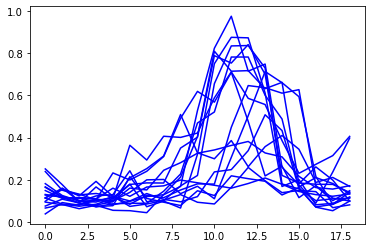

In [10]:
i = 2
a = 0
for j in range(1, len(result)):
  if result[j] == i:
    a = a+1
    plt.plot(band, dataSet[j], 'b-')
print("number = {}".format(a))

In [ ]:
# 打开矢量
csv_origin_dir = r"/content/gdrive/MyDrive/原始样本点NDVI时间序列"
os.chdir(csv_origin_dir)
CSV_list = glob.glob("*.csv")
print(CSV_list)
NDVI = []
i = 4
print(CSV_list[i])
with open(os.path.join(csv_origin_dir, CSV_list[i]), encoding='utf-8-sig') as f :
  for row in csv.reader(f, skipinitialspace=True):
    NDVI.append(row)
n = np.array(NDVI).shape[0]
dataSet = []
for i in range(1, n):
  a = list(map(float, NDVI[i][1:20]))
  dataSet.append(a)
band = range(len(NDVI[0][1:20]))
print(band)
# for i in range(1, n-1):
# plt.plot(band, dataSet[i], 'b-')

from sklearn.cluster import KMeans
import joblib
import numpy
import time
import matplotlib.pyplot as plt

estimator = KMeans(n_clusters=3)#构造聚类器
estimator.fit(dataSet)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和

result = estimator.fit_predict(dataSet)

print("Predicting result: ", result)
# print(len(dataSet))
numSamples = len(dataSet)
# print(centroids,type(centroids)) #显示中心点
# print(estimator.inertia_) #显示聚类效果
mark = ['-r', '-b', '-g', '-k', '^r', '+r', 'sr', 'dr', '<r', 'pr']

['forest.csv', 'wheat.csv', 'corn.csv', 'other.csv', 'cotton.csv']
cotton.csv
range(0, 19)
Predicting result:  [1 0 0 0 2 2 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 2 1
 2 0 2 2 0 0 2 2 1 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 2 0 1 0 0 2 0 1 0 2 0 0 1 0 2 0]


In [ ]:
# def Multipoin2feature(feature):
#   geomList = ee.Feature(feature).geometry().geometries();
#   def GetGeom(geom):
#     return ee.Feature(ee.Geometry(geom));
#   featureList = geomList.map(GetGeom)
#   return featureList;

# multiGeomExplodeList = wheat_corn.toList(wheat_corn.size()).map(Multipoin2feature).flatten();
# multiGeomExplodeFc = ee.FeatureCollection(multiGeomExplodeList);
# print(multiGeomExplodeFc.getInfo());

# size=multiGeomExplodeFc.size()
# toList = multiGeomExplodeFc.toList(size)
# idList = ee.List.sequence(0, size.subtract(1))
# model_list = ee.List(result.tolist())

# def add_property(x):
#   index = model_list.get(x)
#   feat = toList.get(x)
#   return ee.Feature(feat).set('model', index).copyProperties(feat)

# newList = idList.map(add_property)
# print(newList.getInfo(), 'newList')

{'type': 'FeatureCollection', 'columns': {'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [81.30824278265756, 41.606366083788984]}, 'id': '0', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [81.91443946855637, 41.73930677159727]}, 'id': '1', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [81.70163506353462, 41.64233972456299]}, 'id': '2', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [82.18298722914997, 41.80729160035788]}, 'id': '3', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [81.36371785425821, 41.69259455966569]}, 'id': '4', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [81.83905924260212, 41.73789075158561]}, 'id': '5', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [81.78385521515025, 41.7143399049056

In [ ]:
# geemap.ee_export_vector_to_asset(ee.FeatureCollection(newList), description='N_wheat_corn', assetId="projects/ee-gaoliaoran2020/assets/N_wheat_corn")

projects/ee-gaoliaoran2020/assets/N_wheat_corn
Exporting N_wheat_corn... Please check the Task Manager from the JavaScript Code Editor.


number = 5


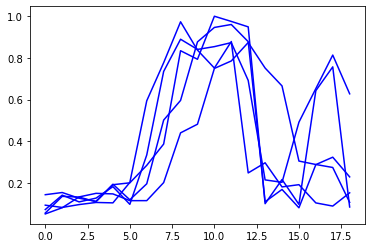

In [ ]:
i = 0
a = 0
for j in range(1, len(result)):
  if result[j] == i:
    a = a+1
    plt.plot(band, dataSet[j], 'b-')
print("number = {}".format(a))

number = 11


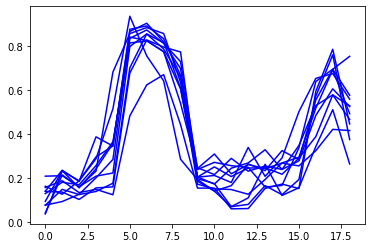

In [ ]:
i = 1
a = 0
for j in range(1, len(result)):
  if result[j] == i:
    a = a+1
    plt.plot(band, dataSet[j], 'b-')
print("number = {}".format(a))

number = 13


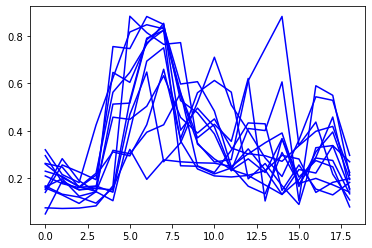

In [ ]:
i = 2
a = 0
for j in range(1, len(result)):
  if result[j] == i:
    a = a+1
    plt.plot(band, dataSet[j], 'b-')
print("number = {}".format(a))